In [ ]:
!pip install medmnist
!pip install torch torchvision
!pip install matplotlib


In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO


In [ ]:
# Choose your dataset flag here:
DATA_FLAG = 'dermamnist'        # e.g. 'dermamnist', 'chestmnist', etc.
BATCH_SIZE = 128
Z_DIM      = 100
EPOCHS     = 10
LR         = 2e-4
IMG_SIZE   = 28
OUT_DIR    = 'output'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs(OUT_DIR, exist_ok=True)

# Utility to display a grid of images
def show_grid(imgs, title=None):
    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0).cpu())
    plt.axis('off')
    if title: plt.title(title)
    plt.show()


In [ ]:
info = INFO[DATA_FLAG]
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

dataset = DataClass(split='train', transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(f"{len(dataset)} training samples of shape {IMG_SIZE}×{IMG_SIZE}")


7007 training samples of shape 28×28


In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim//8, 1)
        self.key   = nn.Conv2d(in_dim, in_dim//8, 1)
        self.value = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        b,c,w,h = x.size()
        q = self.query(x).view(b, -1, w*h).permute(0,2,1)
        k = self.key(x).view(b, -1, w*h)
        attn = self.softmax(torch.bmm(q, k))
        v = self.value(x).view(b, -1, w*h)
        out = torch.bmm(v, attn.permute(0,2,1)).view(b,c,w,h)
        return self.gamma*out + x

class Generator(nn.Module):
    def __init__(self, z_dim, img_shape):
        super().__init__()
        def block(in_f, out_f, norm=True):
            layers = [nn.Linear(in_f, out_f)]
            if norm: layers.append(nn.BatchNorm1d(out_f, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(z_dim, 128, norm=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()
        )
        self.attn = SelfAttention(256)

    def forward(self, z):
        out = self.model(z)
        img = out.view(z.size(0), *IMG_SHAPE)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.attn = SelfAttention(256)
        self.adv  = nn.Sequential(nn.Linear(256,1), nn.Sigmoid())

    def forward(self, img):
        flat = img.view(img.size(0), -1)
        feat = self.model(flat).unsqueeze(-1).unsqueeze(-1)
        feat = self.attn(feat).view(img.size(0), -1)
        return self.adv(feat)

# Instantiate
IMG_SHAPE = (1, IMG_SIZE, IMG_SIZE)
G = Generator(Z_DIM, IMG_SHAPE).to(device)
D = Discriminator(IMG_SHAPE).to(device)
criterion = nn.BCELoss()
optG = optim.Adam(G.parameters(), lr=LR, betas=(0.5,0.999))
optD = optim.Adam(D.parameters(), lr=LR, betas=(0.5,0.999))


[0/10] Batch 0/55 • D: 0.6867, G: 0.7233
-- Epoch 0 samples:


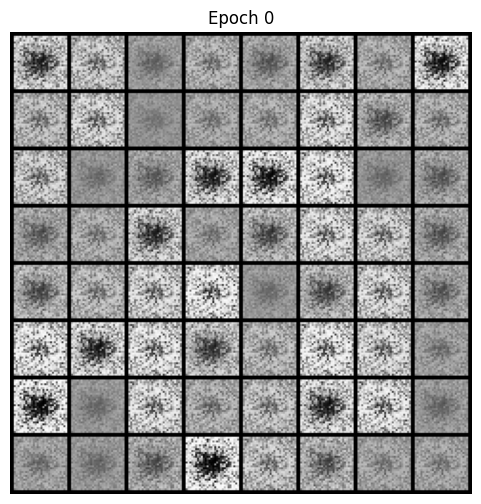

[1/10] Batch 0/55 • D: 0.5374, G: 1.0516
[2/10] Batch 0/55 • D: 0.6825, G: 1.1303
[3/10] Batch 0/55 • D: 0.6320, G: 0.9543
[4/10] Batch 0/55 • D: 0.5838, G: 1.0021
[5/10] Batch 0/55 • D: 0.6054, G: 0.8418
[6/10] Batch 0/55 • D: 0.5490, G: 0.7857
[7/10] Batch 0/55 • D: 0.5045, G: 0.8005
[8/10] Batch 0/55 • D: 0.6193, G: 0.6490
[9/10] Batch 0/55 • D: 0.6349, G: 1.1407


In [ ]:
import torchvision
G_losses, D_losses = [], []

for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        batch = imgs.to(device)
        real = torch.ones(batch.size(0),1,device=device)
        fake = torch.zeros(batch.size(0),1,device=device)

        # Train G
        optG.zero_grad()
        z = torch.randn(batch.size(0), Z_DIM, device=device)
        gen_imgs = G(z)
        g_loss = criterion(D(gen_imgs), real)
        g_loss.backward(); optG.step()

        # Train D
        optD.zero_grad()
        real_loss = criterion(D(batch), real)
        fake_loss = criterion(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss)/2
        d_loss.backward(); optD.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 200 == 0:
            print(f"[{epoch}/{EPOCHS}] Batch {i}/{len(dataloader)} • D: {d_loss:.4f}, G: {g_loss:.4f}")

    # Save & show samples every 10 epochs
    if epoch % 10 == 0:
        with torch.no_grad():
            sample = G(torch.randn(64, Z_DIM, device=device))
            save_image(sample, f"{OUT_DIR}/{epoch}.png", nrow=8, normalize=True)
            print(f"-- Epoch {epoch} samples:")
            show_grid(sample, title=f"Epoch {epoch}")


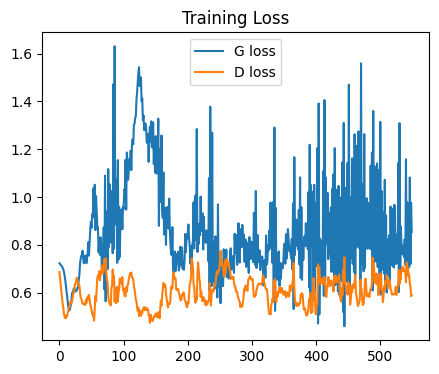

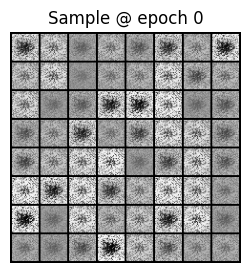

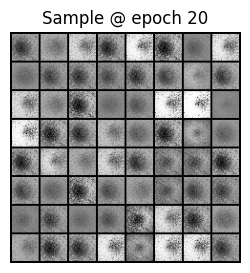

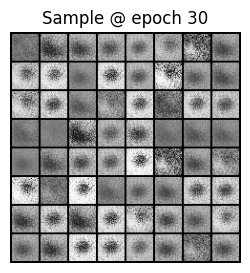

In [ ]:
# Loss curves
plt.figure(figsize=(5,4))
plt.plot(G_losses, label='G loss')
plt.plot(D_losses, label='D loss')
plt.legend(); plt.title("Training Loss"); plt.show()

# Sample grids: first, mid, last
pngs = sorted([f for f in os.listdir(OUT_DIR) if f.endswith('.png')])
for idx in [0, len(pngs)//2, -1]:
    img = Image.open(os.path.join(OUT_DIR, pngs[idx]))
    plt.figure(figsize=(3,3)); plt.imshow(img); plt.axis('off')
    plt.title(f"Sample @ epoch {os.path.splitext(pngs[idx])[0]}")
    plt.show()
